<a href="https://colab.research.google.com/github/Humzafazal72/Part-of-Speech-tagging/blob/main/POS_tagging_with_w2v_%26_Bidirectional_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'named-entity-recognition-ner-corpus:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1861688%2F3043695%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T180633Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c87b754550980229f2b0244068a9fbfe3ad718c68c50de167e66c8c35323a1d706ba8dccd3a6432bce7530cce604bc2a793898b7bdfa31f64a0063b5a318bcdaab0582298ff2849bba53fcbfd5489fee696cf2889790ed8ae2157bbf68c66a32a1175292eab98f2ed65e4b5a5c19c0ed80394a767b74b6219c9288f7eea9fce03e0774a36ebcb03427bcbcb9d56df95bf0ef23805de819ffdd67f3be931676e9ed44165b6dbd8f071b4bc50acf866ede819f94bdf13d1bfebf6ff156a178f56585375d198a3195f039e349e7ab5dbefe9d88401ee323ac639eced023b4869b854b1b56cdd0de0f891546fd939334dc16f315987dc52d2b0f859f0ee67f308fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [1]:
import ast
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,GRU,LSTM,Bidirectional,Embedding,Input

In [ ]:
ds=pd.read_csv('/kaggle/input/named-entity-recognition-ner-corpus/ner.csv')

In [ ]:
#converting the POS column to list (it was previously in string format)
ds['POS']=ds['POS'].apply(ast.literal_eval)

In [ ]:
#cleaning the POS and text column
punctuation="!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'"
omit=["'s","'ll","--",'"','..']
clean_sentences=[]
clean_tags=[]
for i in range(ds.shape[0]):
    sentence=ds['Sentence'][i].lower()
    tag=ds['POS'][i]

    words=sentence.split()
    clean_sentence=[]
    clean_tag=[]
    for j in range(len(words)):
        if words[j] not in punctuation and words[j] not in omit and words[j].isdecimal()!=True and words[j].isnumeric()!=True:
            clean_sentence.append(words[j])
            clean_tag.append(tag[j])
    clean_sentences.append(clean_sentence)
    clean_tags.append(clean_tag)

In [ ]:
#determining all the unique pos tags
unq_tags=[]
for sentence in clean_tags:
    for tag in sentence:
        if tag not in unq_tags:
            unq_tags.append(tag)

In [ ]:
#encoding the previously text tags into numbers
enc={}
for i in range(len(unq_tags)):
    enc[unq_tags[i]]=i

for sentence in clean_tags:
    for idx in range(len(sentence)):
        try:
            sentence[idx]=enc[sentence[idx]]
        except:
            continue

In [ ]:
#Determining what should be the max_len when padding
pad_len=([len(clean_sentences[i]) for i in range(len(clean_sentences))])

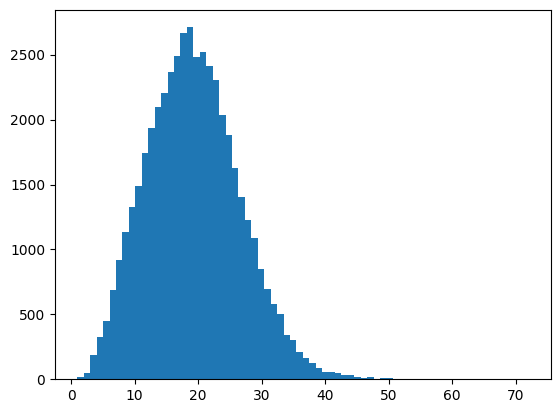

In [ ]:
plt.hist(pad_len,bins=70)
plt.show()

In [ ]:
#tokenization
tokenizer=Tokenizer(oov_token='<unk>',filters='.')
tokenizer.fit_on_texts(clean_sentences)

In [ ]:
w2v_trained=Word2Vec(clean_sentences,vector_size=300,min_count=1)

In [ ]:
#creating the embedding matrix
embedding_matrix=np.zeros((len(tokenizer.word_index)+1,300))
skiped=[]
for word,index in tokenizer.word_index.items():
    try:
        embedding_vec=w2v_trained.wv[word]
    except:
        skiped.append(word)
        continue
    embedding_matrix[index]=embedding_vec

In [ ]:
sequences=tokenizer.texts_to_sequences(clean_sentences)

In [ ]:
import pickle

#with open('/kaggle/working/NER_tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)

In [ ]:
pad_seq = pad_sequences(sequences, maxlen=30, padding='post')

In [ ]:
pad_tag = pad_sequences(clean_tags, maxlen=30, padding='post')

In [ ]:
embedding_matrix[1]=np.random.normal(0, 1, (300,))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pad_seq, pad_tag, test_size=0.15, random_state=42)

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=39)
y_test_one_hot = to_categorical(y_test, num_classes=39)

In [ ]:
gru_model=Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=300, input_length=30, trainable=False, weights=[embedding_matrix]),
    Bidirectional(GRU(512,kernel_regularizer=L2(0.0001),recurrent_regularizer=L2(0.001),return_sequences=True)),
    Dense(39,'softmax')
])

In [ ]:
gru_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=[Precision(),Recall(),'Accuracy'])

In [ ]:
gru_model.fit(x_train,y_train_one_hot,epochs=7)

Epoch 1/2
1274/1274 [==============================] - 14s 11ms/step - loss: 0.2274 - precision: 0.9603 - recall: 0.9222 - Accuracy: 0.9385
Epoch 2/2
1274/1274 [==============================] - 14s 11ms/step - loss: 0.2218 - precision: 0.9611 - recall: 0.9242 - Accuracy: 0.9400


In [ ]:
gru_model.evaluate(x_test,y_test_one_hot)

225/225 [==============================] - 2s 6ms/step - loss: 0.2208 - precision: 0.9613 - recall: 0.9239 - Accuracy: 0.9398


[0.22075533866882324, 0.961251437664032, 0.923927366733551, 0.9397507309913635]

# Just some random testing

In [ ]:
pred=gru_model.predict(x_test[1101].reshape(30,1))

1/1 [==============================] - 0s 20ms/step


In [ ]:
ans=[]
for each in pred:
    m=0
    ind=0
    for i in range(len(each[0])):
        try:
            if each[0][i]>m:
                m=each[0][i]
                ind=i
        except:
            print(each[i])
    ans.append(ind)

In [ ]:
ans,y_test[1101]
np.array(ans)-y_test[1101]